The following tutorial is available on the [Wallaroo Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/2023.3.0-updates/pipeline-edge-publish/edge-cv-healthcare-images).

## Computer Vision Healthcare Images Edge Deployment Demonstration

The following tutorial demonstrates how to use Wallaroo to detect mitochondria from high resolution images, publish the Wallaroo pipeline to an Open Container Initiative (OCI) Registry, and deploy it in an edge system.  For this example we will be using a high resolution 1536x2048 image that is broken down into "patches" of 256x256 images that can be quickly analyzed.

Mitochondria are known as the "powerhouse" of the cell, and having a healthy amount of mitochondria indicates that a patient has enough energy to live a healthy life, or may have underling issues that a doctor can check for.

Scanning high resolution images of patient cells can be used to count how many mitochondria a patient has, but the process is laborious.  The following ML Model is trained to examine an image of cells, then detect which structures are mitochondria.  This is used to speed up the process of testing patients and determining next steps.

## Tutorial Goals

This tutorial will perform the following:

1. As a Data Scientist:
    1. Upload and deploy the `mitochondria_epochs_15.onnx` model to a Wallaroo pipeline.
    1. Randomly select from from a selection of 256x256 images that were originally part of a larger 1536x2048 image.
    1. Convert the images into a numpy array inserted into a pandas DataFrame.
    1. Submit the DataFrame to the Wallaroo pipeline and use the results to create a mask image of where the model detects mitochondria.
    1. Compare the original image against a map of "ground truth" and the model's mask image.
    1. Undeploy the pipeline and return the resources back to the Wallaroo instance.
    1. Publish the pipeline to an Edge deployment registry.
    1. Display different pipeline publishes functions.
1. As a DevOps Engineer:
    1. Deploy the published pipeline through a Docker based deployment.
    1. Perform inference requests using the same data samples as in the Wallaroo deployed pipeline.
    1. Display the results.

## Prerequisites

Complete the steps from Mitochondria Detection Computer Vision Tutorial Part 00: Prerequisites.

## Mitochondria Computer Vision Detection Steps

### Import Libraries

The first step is to import the necessary libraries.  Included with this tutorial are the following custom modules:

* `tiff_utils`: Organizes the tiff images to perform random image selections and other tasks.

Note that tensorflow may return warnings depending on the environment.

In [4]:
import json
import IPython.display as display
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from lib.TiffImageUtils import TiffUtils
import tifffile as tiff
import requests

import pandas as pd

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

import numpy as np
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.utils import normalize


tiff_utils = TiffUtils()

# used for unique connection names

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

### Open a Connection to Wallaroo

The next step is connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  If logging in externally, update the `wallarooPrefix` and `wallarooSuffix` variables with the proper DNS information.  For more information on Wallaroo DNS settings, see the [Wallaroo DNS Integration Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-dns-guide/).

In [5]:
wl = wallaroo.Client()

### Create Workspace and Pipeline

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each Wallaroo instance, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without affecting each other.

In [6]:
suffix='john'
workspace_name = f'edgebiolabsworkspace{suffix}'
pipeline_name = f'edgebiolabspipeline'
model_name = f'edgebiolabsmodel'
model_file_name = 'models/mitochondria_epochs_15.onnx'

In [7]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

In [8]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)
pipeline

{'name': 'edgebiolabspipeline', 'create_time': datetime.datetime(2023, 8, 27, 19, 29, 38, 135888, tzinfo=tzutc()), 'definition': '[]'}

### Upload the Models

Now we will:

1. Upload our model.
1. Apply it as a step in our pipeline.
1. Create a pipeline deployment with enough memory to perform the inferences.
1. Deploy the pipeline.

In [9]:
model = wl.upload_model(model_name, model_file_name, framework=Framework.ONNX)

### Reserve Pipeline Resources

Before deploying an inference engine we need to tell wallaroo what resources it will need.
To do this we will use the wallaroo DeploymentConfigBuilder() and fill in the options listed below to determine what the properties of our inference engine will be.

We will be testing this deployment for an edge scenario, so the resource specifications are kept small -- what's the minimum needed to meet the expected load on the planned hardware.

- cpus - 4 => allow the engine to use 4 CPU cores when running the neural net
- memory - 8Gi => each inference engine will have 8 GB of memory, which is plenty for processing a single image at a time.

In [10]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(4).memory("8Gi").build()



pipeline = wl.build_pipeline(pipeline_name) \
            .clear() \
            .add_model_step(model) \
            .deploy(deployment_config = deployment_config)

In [11]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.3.94',
   'name': 'engine-7cc7c584b5-24wnw',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'edgebiolabspipeline',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'edgebiolabsmodel',
      'version': 'b451d489-7799-48f9-80e2-49f60a3f0504',
      'sha': 'e80fcdaf563a183b0c32c027dcb3890a64e1764d6d7dcd29524cd270dd42e7bd',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.4.109',
   'name': 'engine-lb-584f54c899-vpthw',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

### Retrieve Image and Convert to Data

The next step is to process the image into a numpy array that the model is trained to detect from.

We start by retrieving all the patch images from a recorded time series tiff recorded on one of our microscopes.

For this tutorial, we will be using the path `./patches/condensed`, with a more limited number of images to save on local memory.

In [12]:
sample_mitochondria_patches_path = "./patches/condensed"

patches = tiff_utils.get_all_patches(sample_mitochondria_patches_path)

Randomly we will retrieve a 256x256 patch image and use it to do our semantic segmentation prediction.

We'll then convert it into a numpy array and insert into a DataFrame for a single inference.

The following helper function `loadImageAndConvertTiff` is used to convert the image into a numpy, then insert that into the DataFrame.  This allows a later command to take the randomly grabbed image perform the process on other images.

In [13]:
def loadImageAndConvertTiff(imagePath, width, height):
    img = cv2.imread(imagePath, 0)
    imgNorm = np.expand_dims(normalize(np.array(img), axis=1),2)
    imgNorm=imgNorm[:,:,0][:,:,None]
    imgNorm=np.expand_dims(imgNorm, 0)
    
    resizedImage = None
    #creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
    dictData = {"tensor":[imgNorm]}
    dataframedata = pd.DataFrame(dictData)
    # display(dataframedata)
    return dataframedata, resizedImage

In [14]:
def run_semantic_segmentation_inference(pipeline, input_tiff_image, width, height, threshold):
    
    tensor, resizedImage = loadImageAndConvertTiff(input_tiff_image, width, height)
    # print(tensor)

    # #
    # # run inference on the 256x256 patch image get the predicted mitochandria mask
    # #
    output = pipeline.infer(tensor)
    # print(output)

    # # Obtain the flattened predicted mitochandria mask result
    list1d = output.loc[0]["out.conv2d_37"]
    np1d = np.array(list1d)
    
    # # unflatten it
    predicted_mask = np1d.reshape(1,width,height,1)
    
    # # perform the element-wise comaprison operation using the threshold provided
    predicted_mask = (predicted_mask[0,:,:,0] > threshold).astype(np.uint8)
    
    # return predicted_mask
    return predicted_mask

### Infer and Display Results

We will now perform our inferences and display the results.  This results in a predicted mask showing us where the mitochondria cells are located.

1. The first image is the input image.
1. The 2nd image is the ground truth. The mask was created by a human who identified the mitochondria cells in the input image
1. The 3rd image is the predicted mask after running inference on the Wallaroo pipeline.

We'll perform this 10 times to show how quickly the inferences can be submitted.

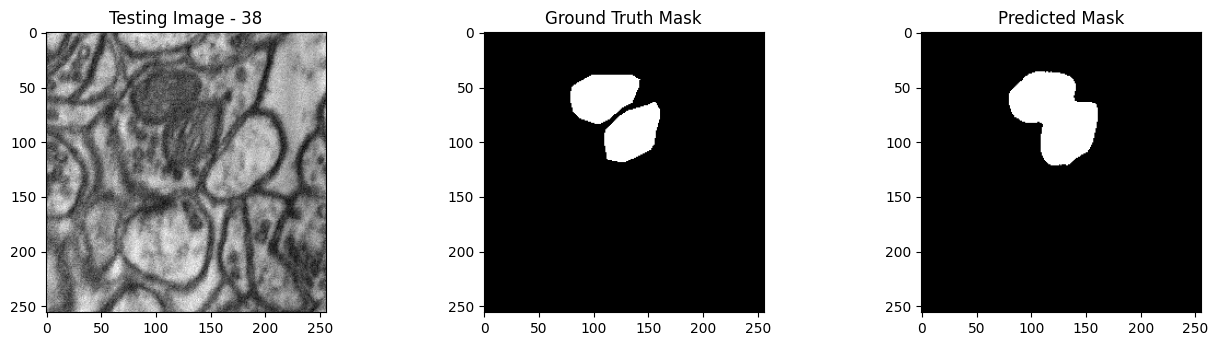

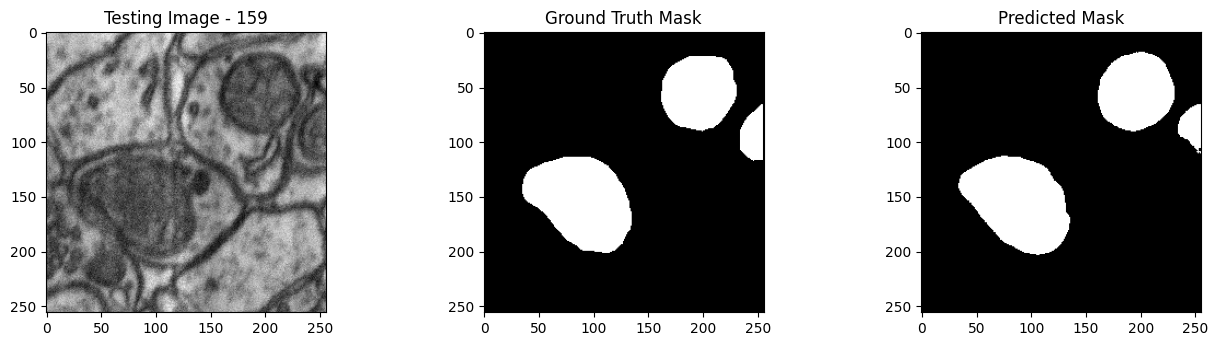

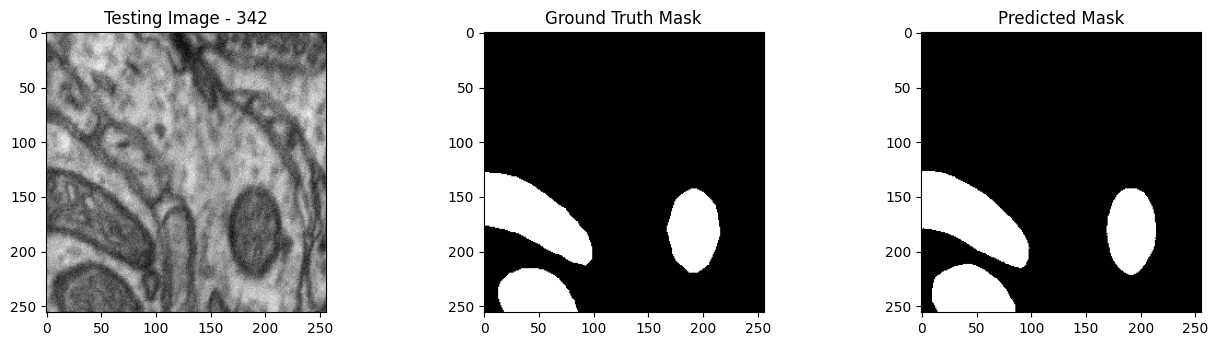

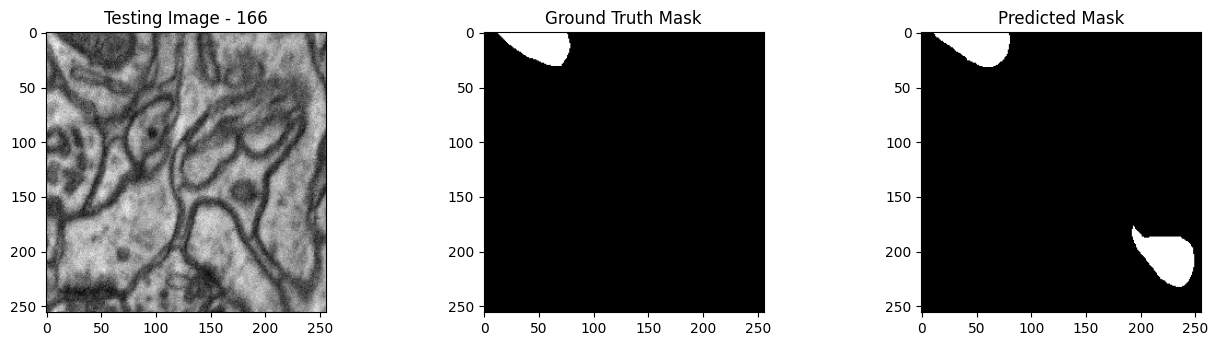

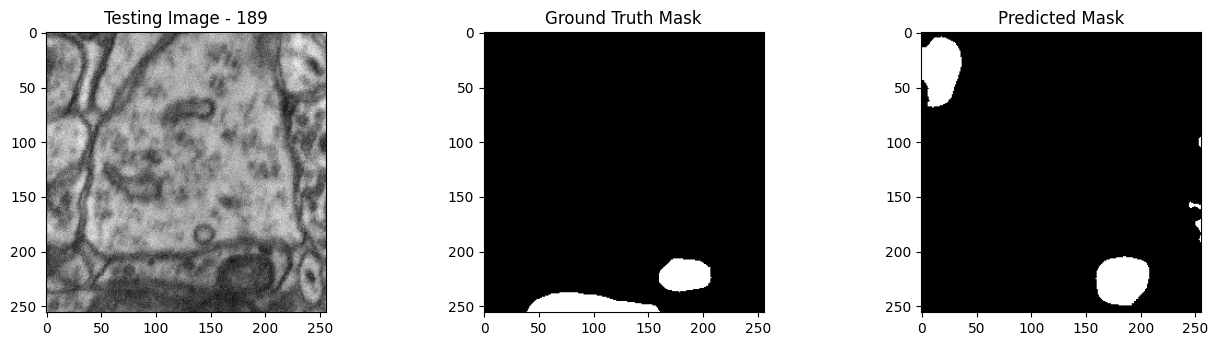

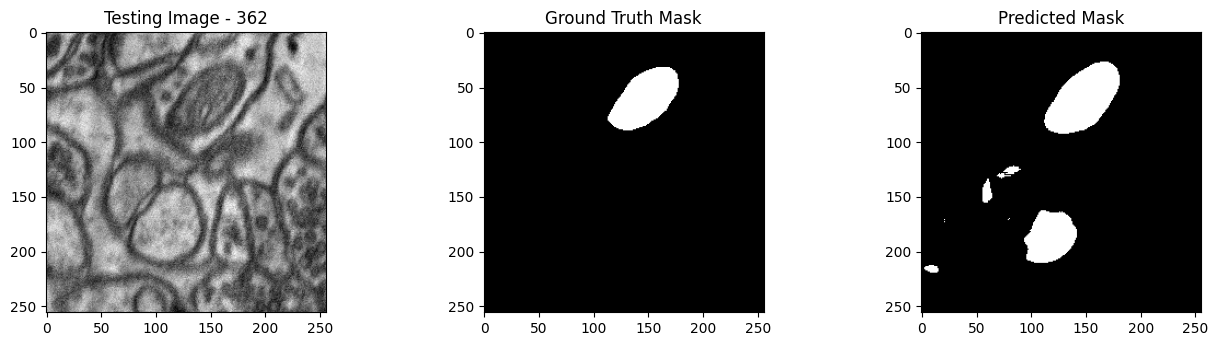

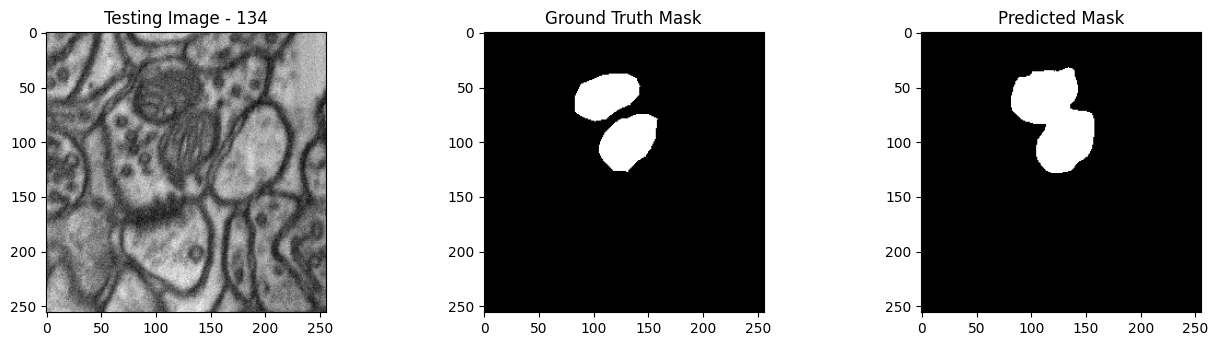

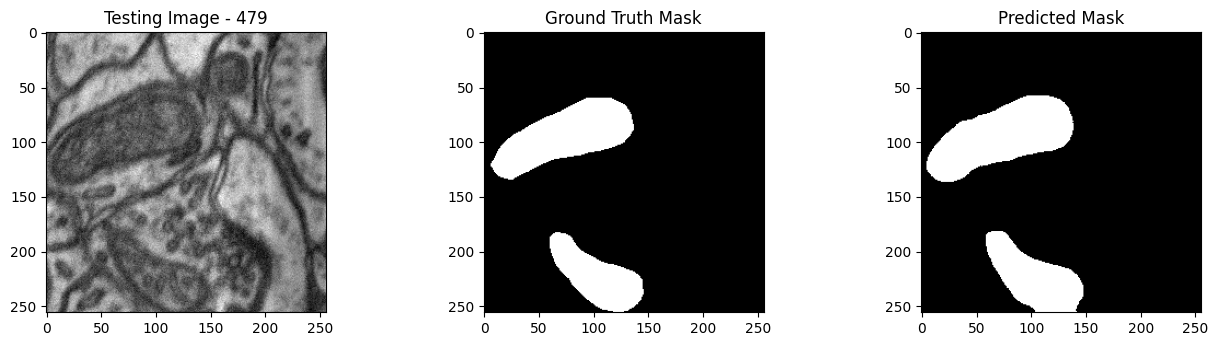

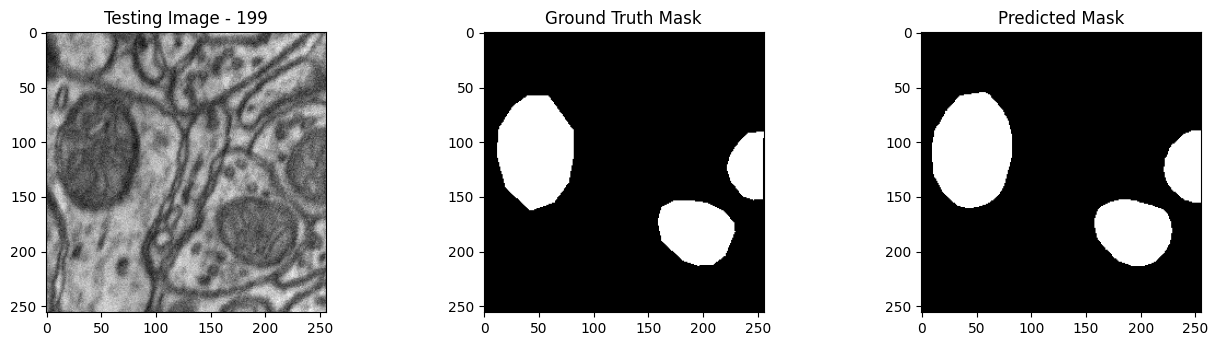

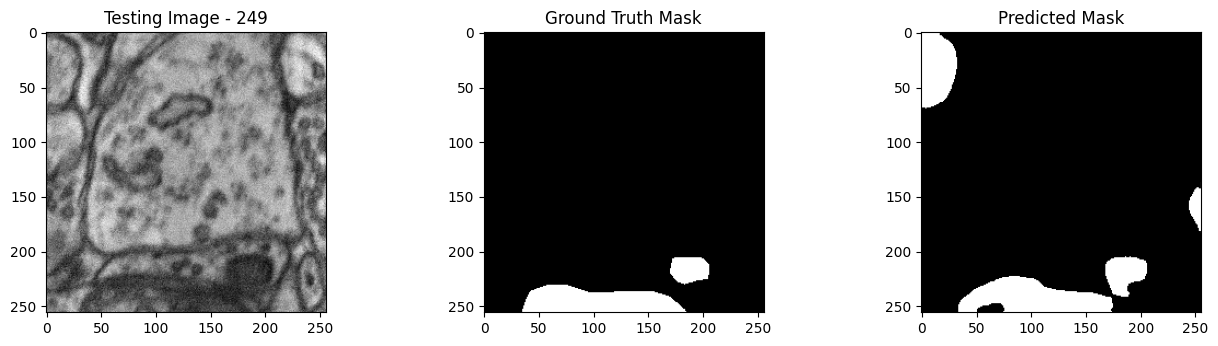

In [15]:
random_patches = []

for x in range(10):
    random_patches.append(tiff_utils.get_random_patch_sample(patches))

for random_patch in random_patches:     
    # get a sample 256x256 mitochondria image
    # random_patch = tiff_utils.get_random_patch_sample(patches)

    # build the path to the image
    patch_image_path = sample_mitochondria_patches_path + "/images/" + random_patch['patch_image_file']

    # run inference in order to get the predicted 256x256 mask
    predicted_mask = run_semantic_segmentation_inference(pipeline, patch_image_path, 256,256, 0.2)

    # # plot the results
    test_image = random_patch['patch_image'][:,:,0]
    test_image_title = f"Testing Image - {random_patch['index']}"

    ground_truth_image = random_patch['patch_mask'][:,:,0]
    ground_truth_image_title = "Ground Truth Mask"

    predicted_mask_title = 'Predicted Mask'

    tiff_utils.plot_test_results(test_image, test_image_title, \
                            ground_truth_image, ground_truth_image_title, \
                            predicted_mask, predicted_mask_title)

### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)` which has the following parameters and returns.

#### Publish a Pipeline Parameters

The `publish` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration]({{<ref "wallaroo-sdk-essentials-pipeline-deployment-config">}}).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### Publish Example

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

In [16]:
pub=pipeline.publish(deployment_config)
pub

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing...Published.


PipelinePublish(created_at=datetime.datetime(2023, 8, 27, 21, 43, 22, 123747, tzinfo=tzutc()), engine_config={'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '8Gi'}, 'requests': {'cpu': 4.0, 'memory': '8Gi'}}}, 'engineAux': {'images': {}}, 'enginelb': {}}, id=8, pipeline_version_id=29, status='Published', updated_at=datetime.datetime(2023, 8, 27, 21, 43, 22, 123747, tzinfo=tzutc()), created_by='db364f8c-b866-4865-96b7-0b65662cb384', engine_url='ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3731', helm={'reference': 'ghcr.io/wallaroolabs/doc-samples/charts@sha256:7485e33084100a7a993e2c00aa9c79719088d866cc8bd71c871e326df0825699', 'chart': 'ghcr.io/wallaroolabs/doc-samples/charts/edgebiolabspipeline', 'version': '0.0.1-d73b969e-7327-4e1c-b756-ae2fd044deb2'}, pipeline_url='ghcr.io/wallaroolabs/doc-samples/pipelines/edgebiolabspipeline:d73b969e-7327-4e1c-b756-ae2fd044deb2', pipeline_version_name='d73b969e-7327-4e1c-b756-ae2fd044deb2', additional_properties={})

### List Published Pipeline

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

In [17]:
wl.list_pipelines()

[{'name': 'edgebiolabspipeline', 'create_time': datetime.datetime(2023, 8, 27, 19, 29, 38, 135888, tzinfo=tzutc()), 'definition': '[]'},
 {'name': 'edge-hf-summarization', 'create_time': datetime.datetime(2023, 8, 25, 18, 53, 19, 465175, tzinfo=tzutc()), 'definition': '[]'},
 {'name': 'hf-summarization-pipeline-edge', 'create_time': datetime.datetime(2023, 8, 25, 15, 52, 2, 329988, tzinfo=tzutc()), 'definition': '[]'},
 {'name': 'houseprice-estimator', 'create_time': datetime.datetime(2023, 8, 24, 21, 16, 0, 405934, tzinfo=tzutc()), 'definition': '[]'},
 {'name': 'edge-pipeline', 'create_time': datetime.datetime(2023, 8, 24, 16, 57, 29, 486951, tzinfo=tzutc()), 'definition': '[]'}]

### List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

#### List Publishes Parameters

N/A

#### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

In [18]:
pipeline.publishes()

[PipelinePublish(created_at=datetime.datetime(2023, 8, 27, 19, 33, 39, 365128, tzinfo=tzutc()), engine_config={'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '8Gi'}, 'requests': {'cpu': 4.0, 'memory': '8Gi'}}}, 'enginelb': {}, 'engineAux': {'images': {}}}, id=6, pipeline_version_id=21, status='Published', updated_at=datetime.datetime(2023, 8, 27, 19, 33, 39, 365128, tzinfo=tzutc()), created_by='db364f8c-b866-4865-96b7-0b65662cb384', engine_url='ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3731', helm={'reference': 'ghcr.io/wallaroolabs/doc-samples/charts@sha256:cd8b4348a7069e7872009c98d9625ec7cfbde6caa210a595db9195b579f14591', 'chart': 'ghcr.io/wallaroolabs/doc-samples/charts/edgebiolabspipeline', 'version': '0.0.1-e45f7703-105f-4b6f-a4b0-33905be1bffd'}, pipeline_url='ghcr.io/wallaroolabs/doc-samples/pipelines/edgebiolabspipeline:e45f7703-105f-4b6f-a4b0-33905be1bffd', pipeline_version_name='e45f7703-105f-4b6f-a4b0-33905be1bffd', additional_properties={}),
 PipelinePublish(created_at=datetime.datetime(2023, 8, 27, 20, 46, 7, 503405, tzinfo=tzutc()), engine_config={'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '8Gi'}, 'requests': {'cpu': 4.0, 'memory': '8Gi'}}}, 'enginelb': {}, 'engineAux': {'images': {}}}, id=7, pipeline_version_id=26, status='Published', updated_at=datetime.datetime(2023, 8, 27, 20, 46, 7, 503405, tzinfo=tzutc()), created_by='db364f8c-b866-4865-96b7-0b65662cb384', engine_url='ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3731', helm={'reference': 'ghcr.io/wallaroolabs/doc-samples/charts@sha256:343a17e8523268e5c4769bb614cbececaf615a57f04acceae9f324c47e514a93', 'chart': 'ghcr.io/wallaroolabs/doc-samples/charts/edgebiolabspipeline', 'version': '0.0.1-3679df28-cf72-4e1f-bee7-7cf3af29a68c'}, pipeline_url='ghcr.io/wallaroolabs/doc-samples/pipelines/edgebiolabspipeline:3679df28-cf72-4e1f-bee7-7cf3af29a68c', pipeline_version_name='3679df28-cf72-4e1f-bee7-7cf3af29a68c', additional_properties={}),
 PipelinePublish(created_at=datetime.datetime(2023, 8, 27, 21, 43, 22, 123747, tzinfo=tzutc()), engine_config={'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '8Gi'}, 'requests': {'cpu': 4.0, 'memory': '8Gi'}}}, 'enginelb': {}, 'engineAux': {'images': {}}}, id=8, pipeline_version_id=29, status='Published', updated_at=datetime.datetime(2023, 8, 27, 21, 43, 22, 123747, tzinfo=tzutc()), created_by='db364f8c-b866-4865-96b7-0b65662cb384', engine_url='ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3731', helm={'reference': 'ghcr.io/wallaroolabs/doc-samples/charts@sha256:7485e33084100a7a993e2c00aa9c79719088d866cc8bd71c871e326df0825699', 'chart': 'ghcr.io/wallaroolabs/doc-samples/charts/edgebiolabspipeline', 'version': '0.0.1-d73b969e-7327-4e1c-b756-ae2fd044deb2'}, pipeline_url='ghcr.io/wallaroolabs/doc-samples/pipelines/edgebiolabspipeline:d73b969e-7327-4e1c-b756-ae2fd044deb2', pipeline_version_name='d73b969e-7327-4e1c-b756-ae2fd044deb2', additional_properties={})]

### Undeploy Pipeline

With the testing complete, the pipeline is undeployed and the resources returned back to the Wallaroo instance.

In [19]:
pipeline.undeploy()

{'name': 'edgebiolabspipeline', 'create_time': datetime.datetime(2023, 8, 27, 19, 29, 38, 135888, tzinfo=tzutc()), 'definition': "[{'ModelInference': {'models': [{'name': 'edgebiolabsmodel', 'version': 'b451d489-7799-48f9-80e2-49f60a3f0504', 'sha': 'e80fcdaf563a183b0c32c027dcb3890a64e1764d6d7dcd29524cd270dd42e7bd'}]}}]"}

## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.

### Docker Deployment

First, the DevOps engineer must authenticate to the same OCI Registry service used for the Wallaroo Edge Deployment registry.

For more details, check with the documentation on your artifact service.  The following are provided for the three major cloud services:

* [Set up authentication for Docker](https://cloud.google.com/artifact-registry/docs/docker/authentication)
* [Authenticate with an Azure container registry](https://learn.microsoft.com/en-us/azure/container-registry/container-registry-authentication?tabs=azure-cli)
* [Authenticating Amazon ECR Repositories for Docker CLI with Credential Helper](https://aws.amazon.com/blogs/compute/authenticating-amazon-ecr-repositories-for-docker-cli-with-credential-helper/)

For the deployment, the engine URL is specified with the following environmental variables:

```bash
{published engine url}
-e DEBUG=true -e OCI_REGISTRY={your registry server} \
-e CONFIG_CPUS=4 \ # optional number of CPUs to use
-e OCI_USERNAME={registry username} \
-e OCI_PASSWORD={registry token here} \
-e PIPELINE_URL={published pipeline url}
```

#### Docker Deployment Example

Using our sample environment, here's sample deployment using Docker with a computer vision ML model, the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```bash
docker run -p 8080:8080 \
    -e DEBUG=true -e OCI_REGISTRY={your registry server} \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=oauth2accesstoken \
    -e OCI_PASSWORD={registry token here} \
    -e PIPELINE_URL={your registry server}/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555 \
    {your registry server}/engine:v2023.3.0-main-3707
```

### Docker Compose Deployment

For users who prefer to use `docker compose`, the following sample `compose.yaml` file is used to launch the Wallaroo Edge pipeline.  This is the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```yml
services:
  engine:
    image: {Your Engine URL}
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: {Your Pipeline URL}
      OCI_REGISTRY: {Your Edge Registry URL}
      OCI_USERNAME:  {Your Registry Username}
      OCI_PASSWORD: {Your Token or Password}
      CONFIG_CPUS: 4
```

For example:

```yml
services:
  engine:
    image: sample-registry.com/engine:v2023.3.0-main-3707
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
      OCI_REGISTRY: sample-registry.com
      OCI_USERNAME:  _json_key_base64
      OCI_PASSWORD: abc123
      CONFIG_CPUS: 4
```

#### Docker Compose Deployment Example

The deployment and undeployment is then just a simple `docker compose up` and `docker compose down`.  The following shows an example of deploying the Wallaroo edge pipeline using `docker compose`.

```bash
docker compose up
[+] Running 1/1
 ✔ Container cv_data-engine-1  Recreated                                                                                                                                                                 0.5s
Attaching to cv_data-engine-1
cv_data-engine-1  | Wallaroo Engine - Standalone mode
cv_data-engine-1  | Login Succeeded
cv_data-engine-1  | Fetching manifest and config for pipeline: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
cv_data-engine-1  | Fetching model layers
cv_data-engine-1  | digest: sha256:c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   filename: c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   name: resnet-50
cv_data-engine-1  |   type: model
cv_data-engine-1  |   runtime: onnx
cv_data-engine-1  |   version: 693e19b5-0dc7-4afb-9922-e3f7feefe66d
cv_data-engine-1  |
cv_data-engine-1  | Fetched
cv_data-engine-1  | Starting engine
cv_data-engine-1  | Looking for preexisting `yaml` files in //modelconfigs
cv_data-engine-1  | Looking for preexisting `yaml` files in //pipelines
```

### Helm Deployment

Published pipelines can be deployed through the use of helm charts.

Helm deployments take up to two steps - the first step is in retrieving the required `values.yaml` and making updates to override.

1. Pull the helm charts from the published pipeline.  The two fields are the Helm Chart URL and the Helm Chart version to specify the OCI .    This typically takes the format of:

  ```bash
  helm pull oci://{published.helm_chart_url} --version {published.helm_chart_version}
  ```

1. Extract the `tgz` file and copy the `values.yaml` and copy the values used to edit engine allocations, etc.  The following are **required** for the deployment to run:

  ```yml
  ociRegistry:
    registry: {your registry service}
    username:  {registry username here}
    password: {registry token here}
  ```

  Store this into another file, suc as `local-values.yaml`.

1. Create the namespace to deploy the pipeline to.  For example, the namespace `wallaroo-edge-pipeline` would be:

  ```bash
  kubectl create -n wallaroo-edge-pipeline
  ```

1. Deploy the `helm` installation with `helm install` through one of the following options:
    1. Specify the `tgz` file that was downloaded and the local values file.  For example:

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {tgz path}
        ```

    1. Specify the expended directory from the downloaded `tgz` file.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {helm directory path}
        ```

    1. Specify the Helm Pipeline Helm Chart and the Pipeline Helm Version.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} oci://{published.helm_chart_url} --version {published.helm_chart_version}
        ```

1. Once deployed, the DevOps engineer will have to forward the appropriate ports to the `svc/engine-svc` service in the specific pipeline.  For example, using `kubectl port-forward` to the namespace `ccfraud` that would be:

    ```bash
    kubectl port-forward svc/engine-svc -n ccfraud01 8080 --address 0.0.0.0`
    ```

The following code segment generates a `docker compose` template based on the previously published pipeline.

In [20]:
docker_compose = f'''
services:
  engine:
    image: {pub.engine_url}
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: {pub.pipeline_url}
      OCI_USERNAME: YOUR USERNAME 
      OCI_PASSWORD: YOUR PASSWORD OR TOKEN
      OCI_REGISTRY: ghcr.io
      CONFIG_CPUS: 4
'''

print(docker_compose)


services:
  engine:
    image: ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3731
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: ghcr.io/wallaroolabs/doc-samples/pipelines/edgebiolabspipeline:d73b969e-7327-4e1c-b756-ae2fd044deb2
      OCI_USERNAME: YOUR USERNAME 
      OCI_PASSWORD: YOUR PASSWORD OR TOKEN
      OCI_REGISTRY: ghcr.io
      CONFIG_CPUS: 4



## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

For this example, the deployment is made on a machine called `testboy.local`.  Replace this URL with the URL of you edge deployment.

In [21]:
!curl testboy.local:8080/pipelines

{"pipelines":[{"id":"edgebiolabspipeline","status":"Running"}]}

The endpoint `/models` returns a List of models with the following fields:

* **name** (*String*): The model name.
* **sha** (*String*): The sha hash value of the ML model.
* **status** (*String*):  The status of either Running or Error if there are any issues.
* **version** (*String*):  The model version.  This matches the version designation used by Wallaroo to track model versions in UUID format.

In [22]:
!curl testboy.local:8080/models

{"models":[{"name":"edgebiolabsmodel","sha":"e80fcdaf563a183b0c32c027dcb3890a64e1764d6d7dcd29524cd270dd42e7bd","status":"Running","version":"b451d489-7799-48f9-80e2-49f60a3f0504"}]}

### Edge Deployed Inference

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.
* `Content-Type: application/json`: JSON.

The `Accept` header will determine what kind format of the data is returned.

* `Accept: application/json`: Returns a JSON object in the following format.

* **check_failures** (*List[Integer]*): Any Validations that failed.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing](https://staging.docs.wallaroo.ai/20230201/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#anomaly-testing)
* **elapsed** (*List[Integer]*): A List of time in nanoseconds for:
  * [0]: The time to serialize the input.
  * [1...n]: How long each step took.
* **model_name** (*String*): The name of the model.
* **model_version** (*String*): The UUID identifier of the model version from Wallaroo.
* **original_data** (*List*): The original submitted data.
* **outputs** (*List*): A List of outputs with each output field corresponding to the input.  This is in the format for each data type returned:
  * **{data-type}**: The data type being returned.
    * **data** (*List*): The data from this data type.
    * **dim** (*List*): The shape of the data for this data type.
* **dim** (*List*): The shape of the data received.
* **pipeline_name** (*String*): The name of the pipeline.
* **shadow_data** (*List*): Any data returned from a shadow deployed model.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Shadow Deployments](https://staging.docs.wallaroo.ai/20230201/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#pipeline-shadow-deployments).
* **time** (*Integer*): The Epoch time of the inference.

We'll repeat our process above - only this time through the Python `requests` library to our locally deployed pipeline.

In [23]:
def loadImageAndConvertTiffList(imagePath, width, height):
    img = cv2.imread(imagePath, 0)
    imgNorm = np.expand_dims(normalize(np.array(img), axis=1),2)
    imgNorm=imgNorm[:,:,0][:,:,None]
    imgNorm=np.expand_dims(imgNorm, 0)
    
    resizedImage = None
    #creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
    dictData = {"tensor":imgNorm.tolist()}
    dataframedata = pd.DataFrame(dictData)
    # display(dataframedata)
    return dataframedata, resizedImage

In [24]:
def run_semantic_segmentation_inference_requests(pipeline_url, input_tiff_image, width, height, threshold):
    
    tensor, resizedImage = loadImageAndConvertTiffList(input_tiff_image, width, height)
    # print(tensor)

    # #
    # # run inference on the 256x256 patch image get the predicted mitochondria mask
    # #

    # set the content type and accept headers
    headers = {
        'Content-Type': 'application/json; format=pandas-records'
    }

    data = tensor.to_json(orient="records")

    # print(data)

    # print(pipeline_url)

    response = requests.post(
                    pipeline_url, 
                    headers=headers, 
                    data=data, 
                    verify=True
                )

    list1d = response.json()[0]['outputs'][0]['Float']['data']

    # output = pipeline.infer(tensor)
    # print(output)

    # # Obtain the flattened predicted mitochandria mask result
    # list1d = output.loc[0]["out.conv2d_37"]
    np1d = np.array(list1d)
    
    # # # unflatten it
    predicted_mask = np1d.reshape(1,width,height,1)
    
    # # # perform the element-wise comaprison operation using the threshold provided
    predicted_mask = (predicted_mask[0,:,:,0] > threshold).astype(np.uint8)
    
    # # return predicted_mask
    return predicted_mask

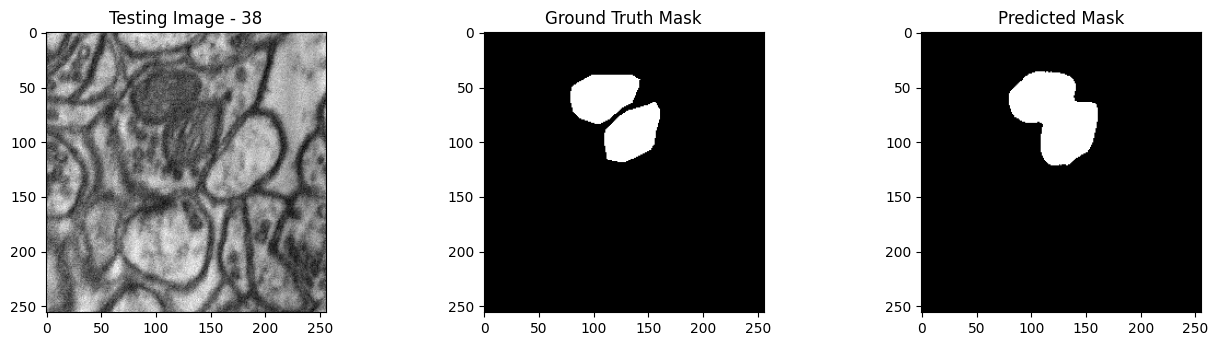

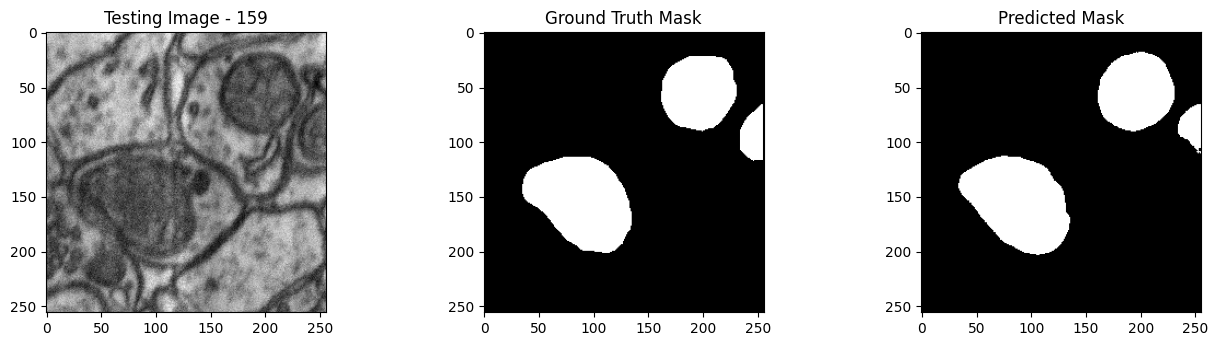

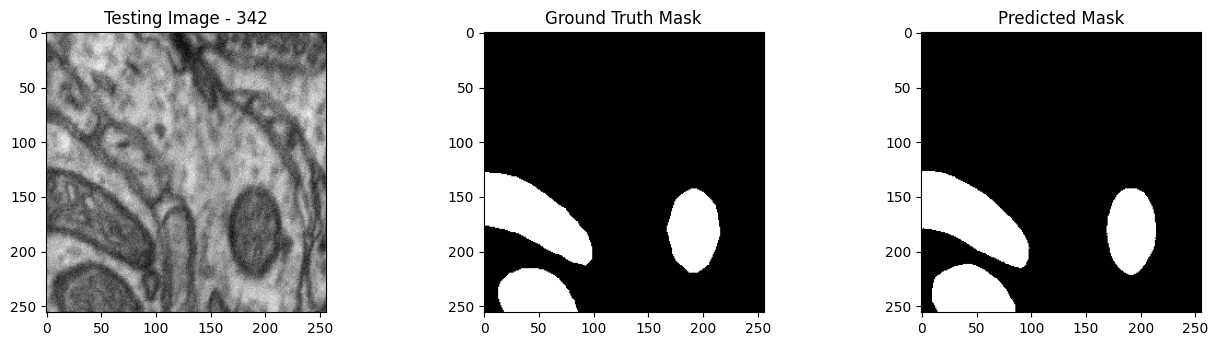

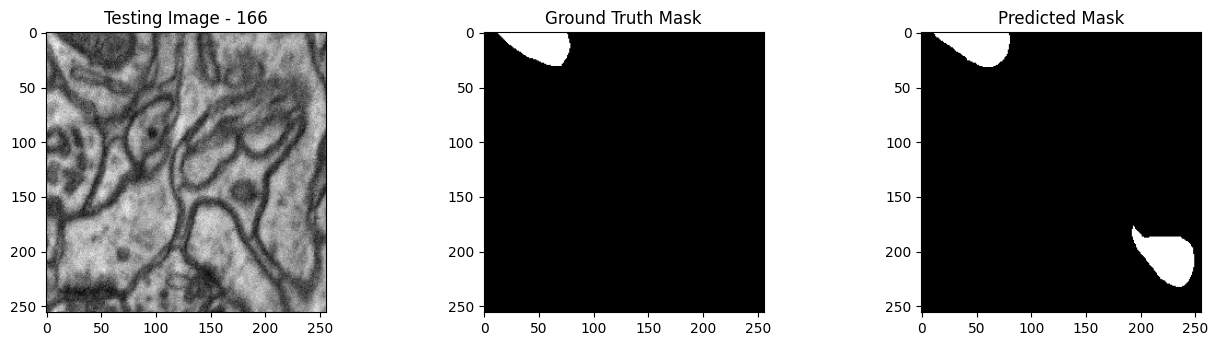

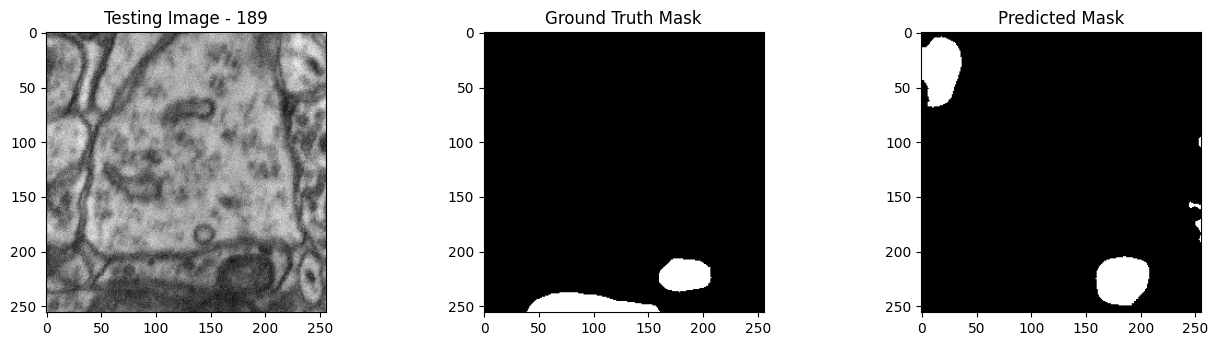

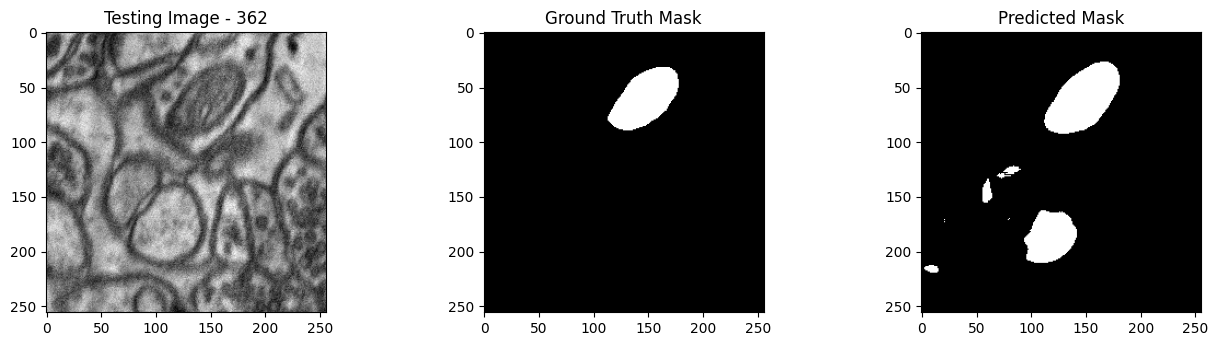

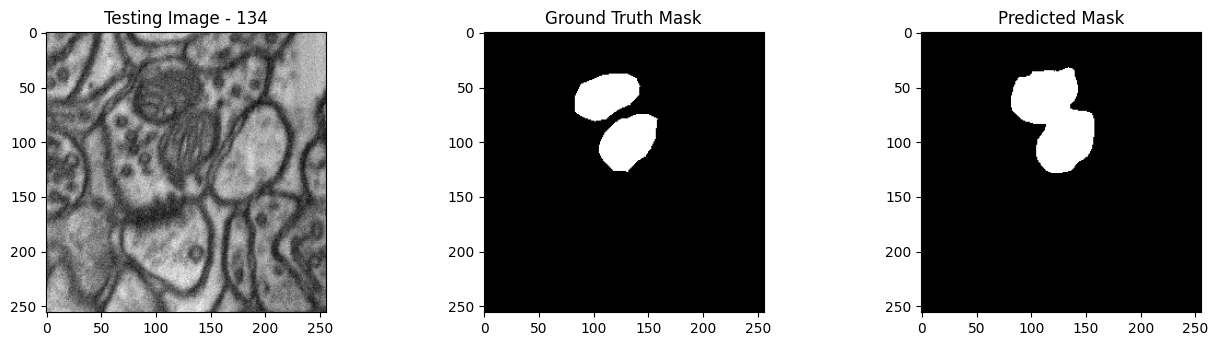

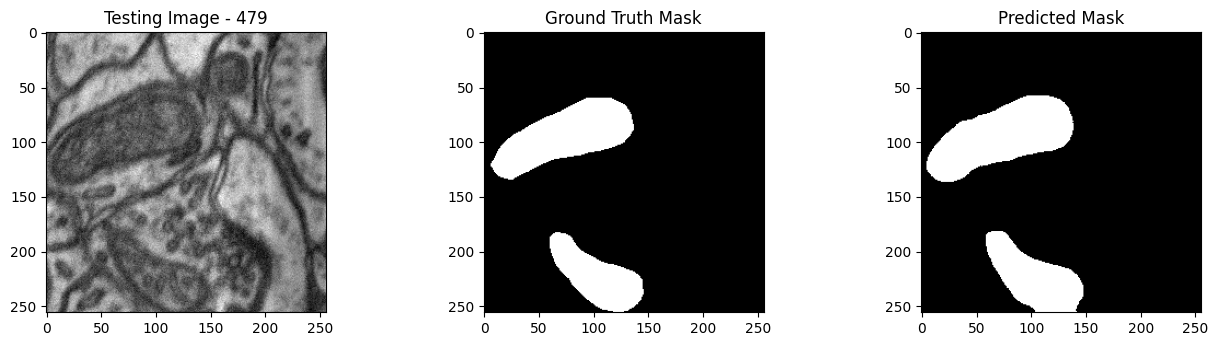

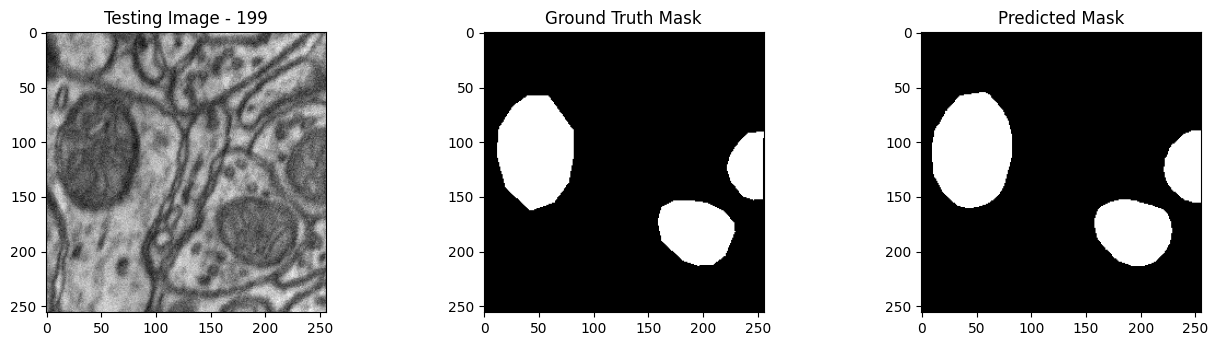

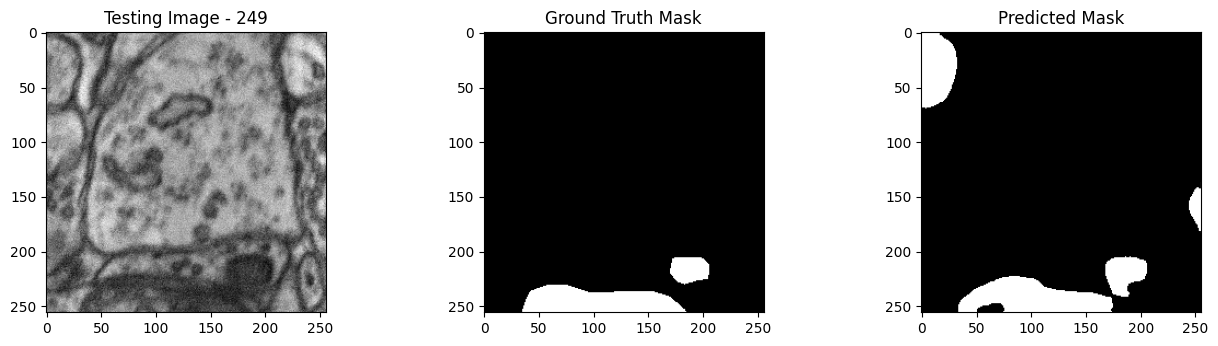

In [25]:
# set this to your deployed pipeline's URL

host = 'http://testboy.local:8080'

deployurl = f'{host}/pipelines/edgebiolabspipeline'

for random_patch in random_patches:      

    # build the path to the image
    patch_image_path = sample_mitochondria_patches_path + "/images/" + random_patch['patch_image_file']

    # run inference in order to get the predicted 256x256 mask
    predicted_mask = run_semantic_segmentation_inference_requests(deployurl, patch_image_path, 256,256, 0.2)
    
    # # plot the results
    test_image = random_patch['patch_image'][:,:,0]
    test_image_title = f"Testing Image - {random_patch['index']}"

    ground_truth_image = random_patch['patch_mask'][:,:,0]
    ground_truth_image_title = "Ground Truth Mask"

    predicted_mask_title = 'Predicted Mask'

    tiff_utils.plot_test_results(test_image, test_image_title, \
                            ground_truth_image, ground_truth_image_title, \
                            predicted_mask, predicted_mask_title)